# 01. Bulk RNA-seq and whole-exome sequencing analysis of MOC1res, MOC1sens, MOC1iso, and parental MOC1 cell lines (in vitro)

In [32]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patheffects import withStroke
from matplotlib.pyplot import rc_context
from adjustText import adjust_text
import anndata as ad
from matplotlib.transforms import Bbox
import re
sc.set_figure_params(dpi_save = 600, fontsize = 12)

## 0. RNA-seq

### 0a. Read in counts and format with metadata

In [2]:
counts = pd.read_csv('/path/to/WT_lines_counts.csv')
counts = counts.rename(columns={'Unnamed: 0': 'Geneid'})

In [3]:
counts = counts.set_index('Geneid')

In [4]:
counts = counts[counts.sum(axis = 1) > 10]

In [5]:
counts = counts[~counts.index.duplicated()]

In [6]:
counts = counts.T

In [10]:
metadata = pd.DataFrame(zip(counts.index, ['WT','WT','WT','WT','WT','WT',
                                           'isotype','isotype','isotype','isotype','isotype','isotype',
                                           'sensitive','sensitive','sensitive','sensitive','sensitive','sensitive',
                                           'resistant','resistant','resistant','resistant','resistant','resistant']),
                        columns = ['Sample', 'Condition'])

In [11]:
metadata = metadata.set_index('Sample')

### 0b. Perform DEseq2 to get normalized counts matrix

In [12]:
dds = DeseqDataSet(counts=counts,
            metadata=metadata,
            design_factors="Condition")

In [13]:
dds.deseq2()

Fitting size factors...
... done in 0.04 seconds.

Fitting dispersions...
... done in 0.94 seconds.

Fitting dispersion trend curve...
... done in 0.23 seconds.

Fitting MAP dispersions...
... done in 1.28 seconds.

Fitting LFCs...
... done in 0.80 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



In [14]:
dds

AnnData object with n_obs × n_vars = 24 × 15747
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [15]:
dds_obs_df = pd.DataFrame(dds.obs)
dds_var_df = pd.DataFrame(dds.var)
dds_matrix_df = pd.DataFrame(dds.layers['normed_counts'], index=dds.obs.index, columns=dds.var.index)

norm_counts = pd.concat([dds_obs_df, dds_matrix_df], axis=1)

### 0c. Convert to adata object

In [23]:
counts = pd.read_csv('/path/to/normalized_counts.csv')

In [26]:
# drop metadata columns
counts_matrix = counts.drop(columns=['Condition','Sample'])

# add metadata columns to a designated dataframe
metadata = counts[['Sample', 'Condition']].copy()

# create a DataFrame for gene names
var_df = pd.DataFrame(index=counts_matrix.columns)

# create the AnnData object
adata = ad.AnnData(X=counts_matrix.values, obs=metadata, var=var_df)

adata.obs.index = counts_matrix.index

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [27]:
adata.raw = adata

### 0d. Plot marker gene expression in all 4 cell lines 

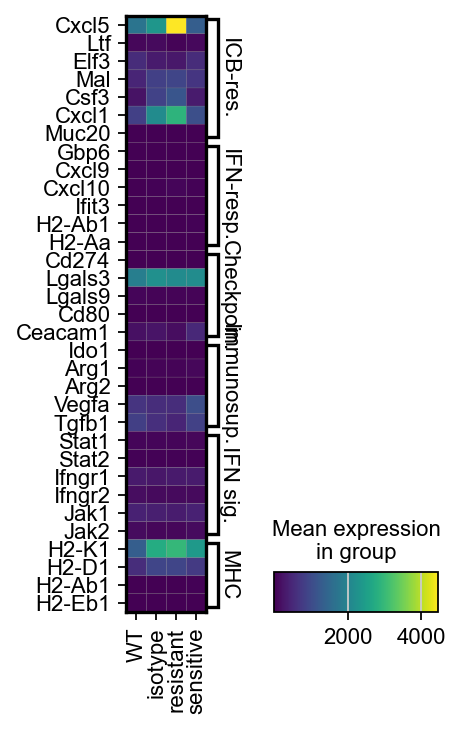

In [28]:
markers = {'ICB-res.': ['Cxcl5','Ltf','Elf3','Mal','Csf3','Cxcl1','Muc20'],
          'IFN-resp.': ['Gbp6','Cxcl9','Cxcl10','Ifit3','H2-Ab1','H2-Aa'],
          'Checkpoint ligands': ['Cd274','Lgals3','Lgals9','Cd80','Ceacam1'], 
           'Immunosupp.': ['Ido1','Arg1','Arg2','Vegfa','Tgfb1'],
           'IFN sig.':['Stat1','Stat2','Ifngr1', 'Ifngr2','Jak1','Jak2'],
            'MHC':['H2-K1','H2-D1','H2-Ab1','H2-Eb1']}
sc.pl.matrixplot(adata, markers, groupby='Condition', 
                 dendrogram=False, use_raw=True, figsize = (2.5,4.5),
                 swap_axes=True,
                )

### 0e. Plot sustained gene expression (for comparison with MOC1(IFN)

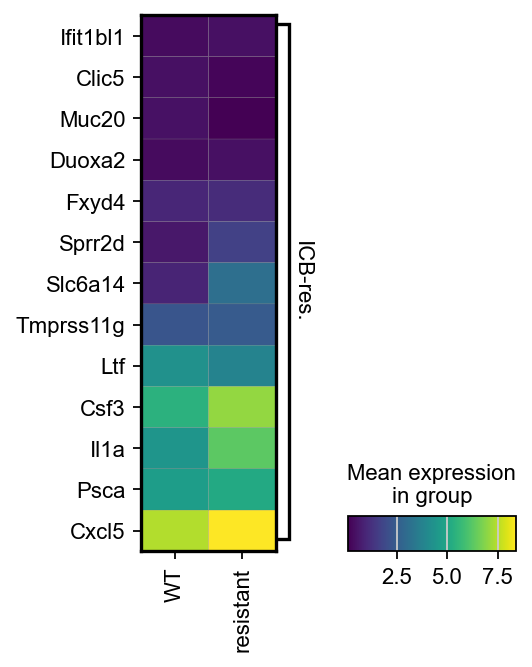

In [31]:
markers = {'ICB-res.': ['Ifit1bl1','Clic5','Muc20','Duoxa2','Fxyd4','Sprr2d','Slc6a14','Tmprss11g',
                         'Ltf','Csf3','Il1a','Psca','Cxcl5'
                ]}
sc.pl.matrixplot(adata[adata.obs['Condition'].isin(['WT','resistant'])], markers, groupby='Condition', 
                 dendrogram=False, use_raw=True, figsize = (3,4),
                 swap_axes=True, log=True,
                )

## 1. Whole-exome sequencing

### 1a. read in data 

In [33]:
# read the unique snp file into a dataframe
snpeff = pd.read_csv('/path/to/RS32B_uniq.snpeff', sep='\t', header=None, skiprows=119)

# rename the columns for interpretability
snpeff.columns = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'RS32A', 'RS32B', 'RS32C', 'RS32E']

In [34]:
snpeff

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,RS32A,RS32B,RS32C,RS32E
0,1,3286653,.,G,T,-1.0,PASS,AC=1;AN=8;NS=4;NS_GT=4;NS_NOGT=0;NS_NODATA=0;I...,GT:GQ:AD:FT:LPL:LAA,0/0:.:51:PASS:.:.,"0/1:.:43,3:PASS:.:1",0/0:.:64:PASS:.:.,0/0:.:51:PASS:.:.
1,1,4562065,.,G,T,-1.0,PASS,AC=1;AN=8;NS=4;NS_GT=4;NS_NOGT=0;NS_NODATA=0;I...,GT:GQ:AD:FT:LPL:LAA,0/0:.:62:weak_evidence:.:.,"0/1:.:57,3:PASS:.:1",0/0:.:63:PASS:.:.,0/0:.:48:PASS:.:.
2,1,9616566,.,G,T,-1.0,PASS,AC=1;AN=8;NS=4;NS_GT=4;NS_NOGT=0;NS_NODATA=0;I...,GT:GQ:AD:FT:LPL:LAA,"0/0:.:40,18:ggf;weak_evidence:.:1","0|1:.:25,12:PASS:.:1","0/0:.:35,8:ggf;weak_evidence:.:1","0/0:.:44,9:ggf;weak_evidence:.:1"
3,1,9616813,.,A,T,-1.0,PASS,AC=1;AN=8;NS=4;NS_GT=4;NS_NOGT=0;NS_NODATA=0;I...,GT:GQ:AD:FT:LPL:LAA,0/0:.:45:weak_evidence:.:.,"0|1:.:24,5:PASS:.:1","0/0:.:43,9:ggf;weak_evidence:.:1","0/0:.:40,5:ggf;weak_evidence:.:1"
4,1,33815657,.,G,T,-1.0,PASS,AC=1;AN=8;NS=4;NS_GT=4;NS_NOGT=0;NS_NODATA=0;I...,GT:GQ:AD:FT:LPL:LAA,0/0:.:133:weak_evidence:.:.,"0/1:.:149,3:PASS:.:1",0/0:.:159:PASS:.:.,0/0:.:169:PASS:.:.
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,X,166261743,.,C,A,-1.0,PASS,AC=1;AN=8;NS=4;NS_GT=4;NS_NOGT=0;NS_NODATA=0;I...,GT:GQ:AD:FT:LPL:LAA,0/0:.:75:weak_evidence:.:.,"0/1:.:69,3:PASS:.:1",0/0:.:82:PASS:.:.,0/0:.:94:PASS:.:.
568,X,168040706,.,C,A,-1.0,PASS,AC=1;AN=8;NS=4;NS_GT=4;NS_NOGT=0;NS_NODATA=0;I...,GT:GQ:AD:FT:LPL:LAA,0/0:.:100:PASS:.:.,"0/1:.:145,3:PASS:.:1",0/0:.:186:PASS:.:.,0/0:.:185:weak_evidence:.:.
569,GL456211.1,113987,.,C,T,-1.0,PASS,AC=1;AN=8;NS=4;NS_GT=4;NS_NOGT=0;NS_NODATA=0;I...,GT:GQ:AD:FT:LPL:LAA,"0/0:.:327,45:filtered_reads;ggf:.:1","0/1:.:379,50:PASS:.:1","0/0:.:422,58:filtered_reads;ggf:.:1","0/0:.:360,52:filtered_reads;ggf:.:1"
570,GL456221.1,75606,.,A,AC,-1.0,PASS,AC=1;AN=8;NS=4;NS_GT=4;NS_NOGT=0;NS_NODATA=0;I...,GT:GQ:AD:FT:LPL:LAA,"0/0:.:37,7:ggf;mapping_quality:.:1","0/1:.:44,14:PASS:.:1","0/0:.:32,10:ggf;mapping_quality:.:1","0/0:.:36,4:ggf;no_reliable_supporting_read;rea..."


### 1b. Count types of variants

In [35]:
# extract TYPE and GENE_NAME from the INFO column
snpeff['TYPE'] = snpeff['INFO'].str.extract(r'EFF=([^|]+)')
snpeff['GENE_NAME'] = snpeff['INFO'].str.extract(r'EFF=[^|]+\|([^|]+)')

# display the updated DataFrame
snpeff.TYPE.value_counts()

TYPE
NON_SYNONYMOUS_CODING(MODERATE    240
SYNONYMOUS_CODING(LOW              97
UPSTREAM(MODIFIER                  65
INTRON(MODIFIER                    60
DOWNSTREAM(MODIFIER                35
STOP_GAINED(HIGH                   28
EXON(MODIFIER                      18
UTR_3_PRIME(MODIFIER               15
INTERGENIC(MODIFIER                 4
UTR_5_PRIME(MODIFIER                3
SPLICE_SITE_DONOR(HIGH              2
CODON_DELETION(MODERATE             1
START_LOST(HIGH                     1
SPLICE_SITE_ACCEPTOR(HIGH           1
START_GAINED(LOW                    1
FRAME_SHIFT(HIGH                    1
Name: count, dtype: int64

### 1c. Extract mutations specific to MOC1res and their associated genes

In [38]:
def extract_gene_name(info):
    # split the INFO string by "|"
    info_parts = info.split("|")
    if len(info_parts) >= 6:
        # extract and return the gene name
        return info_parts[4].strip()
    else:
        # return None if gene name is not found
        return None

In [39]:
snpeff['GENE_NAME'] = snpeff['INFO'].apply(extract_gene_name)

In [40]:
# filter out synonymous mutations
types_of_interest = ['SYNONYMOUS_CODING(LOW']

# Filter the DataFrame based on the types of interest
snpeff_filt = snpeff[~snpeff.TYPE.isin(types_of_interest)]

len(snpeff_filt)

475

In [41]:
mutated_genes = snpeff_filt.GENE_NAME.to_list()

### 1d. Determine variant allele frequencies

In [47]:
# function allows the user to test if a specific gene has a mutation

def extract_AF(gene_name, df):
    # filter the DataFrame for rows containing the gene name
    gene_rows = df[df['GENE_NAME'] == gene_name]
    
    if gene_rows.empty:
        return "Gene not found in DataFrame"
    
    # get the value under the 'RS32B' (MOC1res sample) column for the first row containing the gene
    rs32b_value = gene_rows.iloc[0]['RS32B']
    
    # split by ':'
    rs32b_parts = rs32b_value.split(':')
    
    # extract allele frequencies
    allele_freq_part = rs32b_parts[2]
    
    # split the allele frequencies
    allele_freqs = allele_freq_part.split(',')
    
    # extract the allele frequencies
    ref_af = allele_freqs[0]
    alt_af = allele_freqs[1]
    
    # Return the result
    return f"Ref reads: {ref_af}     Alt reads: {alt_af}"

In [54]:
extract_AF('Jak2', snpeff)

'Ref reads: 63     Alt reads: 3'

### 1e. Find genes with the highest VAFs

In [49]:
def find_top_var_AF_sorted(df, top_n=len(snpeff)):
    # extract number1 and number2 from RS32B column
    df['ref_reads'] = df['RS32B'].str.split(':').str[2].str.split(',').str[0].astype(float)
    df['alt_reads'] = df['RS32B'].str.split(':').str[2].str.split(',').str[1].astype(float)
    
    # calculate the ratio of number1 to number2
    df['ratio'] = df['alt_reads'] / (df['ref_reads']+ df['alt_reads'])
    
    # sort DataFrame by the ratio in descending order
    sorted_df = df.sort_values(by='ratio', ascending=False)
    
    # get top n gene names and their corresponding number1, number2, and ratio values
    top_genes = sorted_df[['GENE_NAME', 'ref_reads', 'alt_reads', 'ratio']].head(top_n)

    return top_genes

top_genes = find_top_var_AF_sorted(snpeff)

In [50]:
top_genes

,GENE_NAME,ref_reads,alt_reads,ratio
449,Gm9697,0.0,13.0,1.000000
241,Pde2a,0.0,16.0,1.000000
409,Tmem267,0.0,3.0,1.000000
425,Gm26178,1.0,8.0,0.888889
473,Ager,1.0,7.0,0.875000
...,...,...,...,...
410,Gm5458,570.0,4.0,0.006969
521,Ssxb6,813.0,5.0,0.006112
164,Fam3c,17.0,0.0,0.000000
306,Gm10163,8.0,0.0,0.000000


In [51]:
top_genes = top_genes.sort_values(by='ratio', ascending=False).reset_index(drop=True)


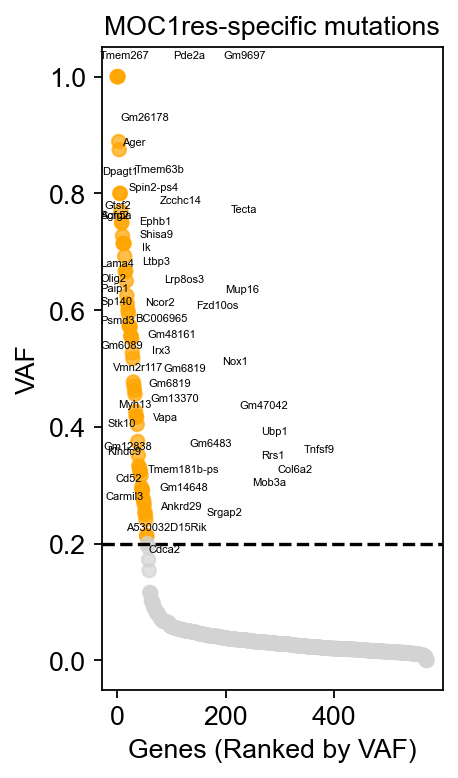

In [52]:
# Plot genes with highest VAFs
plt.figure(figsize=(3, 5))
scatter = plt.scatter(top_genes.index, top_genes['ratio'], 
                      color=['orange' if ratio > 0.2 else 'lightgrey' for ratio in top_genes['ratio']], 
                      alpha=0.7)
plt.title('MOC1res-specific mutations')
plt.xlabel('Genes (Ranked by VAF)')
plt.ylabel('VAF')
plt.grid(False) 

# draw a horizontal dashed line at y=0.2
plt.axhline(y=0.2, color='black', linestyle='--')

# annotate genes with VAF higher than 0.2
texts = []
for i, row in top_genes.iterrows():
    if row['ratio'] > 0.2:
        texts.append(
            plt.text(
                i, row['ratio'], row['GENE_NAME'], ha='left', va='bottom',fontsize=5
            )
        )

# adjust text to prevent overlap with points
bbox_list = [Bbox([[x, y], [x, y]]) for x, y in zip(top_genes.index, top_genes['ratio'])]
adjust_text(texts, objects=bbox_list, force_text=(2.2, .1))
plt.tight_layout(pad=1.0)
#plt.savefig('VAF_MOC1res.png', dpi=300)

plt.show()